# Load data

In [1]:
import os
import pandas as pd

import pickle
from collections import Counter
from tqdm import tqdm
import numpy as np
import random

import json
import ast

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(style="darkgrid")

In [2]:
with open(f'{os.getcwd()}/../AbstractiveSubjectivity/data/AITA/author_to_subID_to_Values_withCommValueTradeoff.pkl', 'rb') as f:
    author_to_subID_to_Values = pickle.load(f)

In [3]:
subID_to_value = {}

for _author in author_to_subID_to_Values:
    for _subID in author_to_subID_to_Values[_author]:
        if _subID in subID_to_value:
            continue
            
        situation_values = ast.literal_eval(author_to_subID_to_Values[_author][_subID][0])
        situation_values = [elem for elem in situation_values if 'vs.' in elem]
        subID_to_value[_subID] = "\n".join(situation_values)

In [2]:
df = pd.read_csv(f"{os.getcwd()}/data/data_active.tsv", sep="\t")

In [5]:
df.head()

,subID,title,selftext,commAuthor,comment,judgment
0,k8zq74,not doing my stepchildren's hair?,"Hello, I'm 30F married to my partner 51M and h...",NoApollonia,The children are both old enough to choose if ...,1
1,k93tjn,insulting my wife in front of our son.,Growing up I had faced a few key issues that I...,NoApollonia,Don't disrespect your wife in front of your so...,0
2,k96h8e,telling my daughter to suck it up?,I (43M) and my wife (45F) have three kids: 12F...,NoApollonia,While I agree the two sisters should share a r...,0
3,k9o2vg,refusing to help my husband financially,So firstly English isn't my first language so ...,WebbieVanderquack,". You don't have to give him 1K, especially if...",0
4,k9om9o,telling my friend to take off her makeup?,I'm new to this but just a few minutes ago me ...,WebbieVanderquack,", both for not using punctuation and for telli...",0


In [6]:
subID_to_situ = {}
for idx, row in df.iterrows():
    if row['subID'] in subID_to_situ:
        continue
    subID_to_situ[row['subID']] = row['title']

## Prompt gpt to annotate Schwartz's value

In [29]:
import openai
from openai import OpenAI
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)

# Load your API key from an environment variable or secret management service
openai.api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI()

@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def completion_with_backoff(**kwargs):
    return client.chat.completions.create(**kwargs)

In [47]:
PROMPT = """
You will be given a list of values conflicting in some social situations.
Your job is to match each of these values to one of the Schwartz's Basic Human Values that align the most.
Follow the format below without generating any other explanation.
Input Format:
[Situation] situation_description
[Conflicting Values]
- input_value_A vs. input_value_B
- input_value_C vs. input_value_D
..
Output Format:
- Schwartz_value_of_A vs. Schwartz_value_of_B
- Schwartz_value_of_C vs. Schwartz_value_of_D
..
"""
subID_to_schwartz = {}
for _subID in tqdm(subID_to_value):
    message_list = [
        {"role": "user", "content": PROMPT},
        {"role": "user", "content": f"[Situation] {subID_to_situ[_subID]}\n[Conflicting Values]\n{subID_to_value[_subID]}"},
    ]
    
    response = completion_with_backoff(model='gpt-4o-mini', messages=message_list)
    subID_to_schwartz[_subID] = response.choices[0].message.content
    # responses.append(response.choices[0].message.content)
with open(f'{os.getcwd()}/data/subID_to_SchwartzValueMapping.pkl', 'wb') as f:
    pickle.dump(subID_to_schwartz, f)

100%|██████████████████████████████████████████████████████████████████| 17432/17432 [4:48:17<00:00,  1.01it/s]


In [121]:
PROMPT = """
You will be given a list of values conflicting in some social situations.
Your job is to match each of these values to one of the Schwartz's Basic Human Values that align the most.
Follow the format below without generating any other explanation.
Input Format:
[Situation] situation_description
[Conflicting Values]
- input_value_A vs. input_value_B
- input_value_C vs. input_value_D
..
Output Format:
- Schwartz_value_of_A vs. Schwartz_value_of_B
- Schwartz_value_of_C vs. Schwartz_value_of_D
..
"""
subID_to_schwartz = {}
for _subID in tqdm(subID_to_value):
    message_list = [
        {"role": "user", "content": PROMPT},
        {"role": "user", "content": f"[Situation] {subID_to_situ[_subID]}\n[Conflicting Values]\n{subID_to_value[_subID]}"},
    ]
    
    response = completion_with_backoff(model='gpt-4o', messages=message_list)
    subID_to_schwartz[_subID] = response.choices[0].message.content
    # responses.append(response.choices[0].message.content)
with open(f'{os.getcwd()}/data/subID_to_SchwartzValueMapping_4o.pkl', 'wb') as f:
    pickle.dump(subID_to_schwartz, f)

100%|██████████████████████████████████████████████████████████████████| 17432/17432 [5:26:30<00:00,  1.12s/it]


# Check values w.r.t. Schwartz values

In [3]:
df_values = pd.read_csv(f'{os.getcwd()}/../AbstractiveSubjectivity/data/AITA/directComms_withValuesRefined_withThemes.tsv', sep='\t') 

In [4]:
with open(f'{os.getcwd()}/data/subID_to_SchwartzValueMapping_4o.pkl', 'rb') as f:
    subID_to_schwartz = pickle.load(f)

In [5]:
def process_sch_val(text):
    a = _schwartz.split('vs.')[0].strip()
    b = _schwartz.split('vs.')[1].strip()
    if a.startswith("-"):
        a = a[1:]
    if b.startswith("-"):
        b = b[1:]
    return a.strip(), b.strip()

In [6]:
values_to_IDs, IDs_to_values = {}, {}
values_to_schwartz = {}
invalid_output_cases = 0
valud_idx = 0
value_cnt = Counter()
# for subID, item in zip(df_values.subID.tolist(), df_values.situ_val_pattern_cats.tolist()):
for subID, item in zip(df_values.subID.tolist(), df_values.situ_val_patterns.tolist()):
    invalid_ = False
    value_list = item.split('\n')
    schwartz_list = subID_to_schwartz[subID].split('\n')
    if len(value_list) != len(schwartz_list):
        invalid_output_cases += 1
        continue
    for elem in schwartz_list:
        if len(elem.split('vs.')) != 2:
            invalid_output_cases += 1
            invalid_ = True
            continue
    if invalid_:
        continue
    _list = []
    for idx, (_values,_schwartz) in enumerate(zip(value_list, schwartz_list)):
        a = _values.split(' vs. ')[0].strip()
        b = _values.split(' vs. ')[1].strip()
        if a not in values_to_IDs:
            values_to_IDs[a] = valud_idx
            IDs_to_values[valud_idx] = a
            valud_idx += 1
        if b not in values_to_IDs:
            values_to_IDs[b] = valud_idx
            IDs_to_values[valud_idx] = b
            valud_idx += 1
        _list += [a, b]

        sch_a, sch_b = process_sch_val(_schwartz)
        if a not in values_to_schwartz:
            values_to_schwartz[a] = [sch_a]
        else:
            values_to_schwartz[a].append(sch_a)
        if b not in values_to_schwartz:
            values_to_schwartz[b] = [sch_b]
        else:
            values_to_schwartz[b].append(sch_b)
    value_cnt.update(_list)

### value-schwartz heatmap

In [7]:
schwartz_values = ['self-direction', 'universalism', 'benevolence', 'conformity', 'tradition', 
                   'security', 'power', 'achievement', 'hedonism', 'stimulation']
Schwartz_Values = ['Self-Direction', 'Universalism', 'Benevolence', 'Conformity', 'Tradition', 
                   'Security', 'Power', 'Achievement', 'Hedonism', 'Stimulation']
s_to_S = {item1:item2 for item1,item2 in zip(schwartz_values, Schwartz_Values)}

In [8]:
# Get list of values, sorted by their occurrence
value_cnt_sorted = sorted(value_cnt.items(), key=lambda x:x[1], reverse=True)
value_cnt_sorted[:10]

[('Individual Autonomy Emphasis', 4089),
 ('Personal Boundaries and Well-being', 3374),
 ('Commitment and Responsibility', 2965),
 ('Independence in Personal Life', 2635),
 ('Familial Loyalty Dynamics', 2131),
 ('Familial Obligations and Responsibilities', 1781),
 ('Interpersonal Dynamics and Control', 1770),
 ('Freedom of Choice', 1686),
 ('Personal Comfort Importance', 1637),
 ('Boundary Awareness and Respect', 1563)]

<Axes: xlabel="Schwartz's Values", ylabel='LLM Values'>

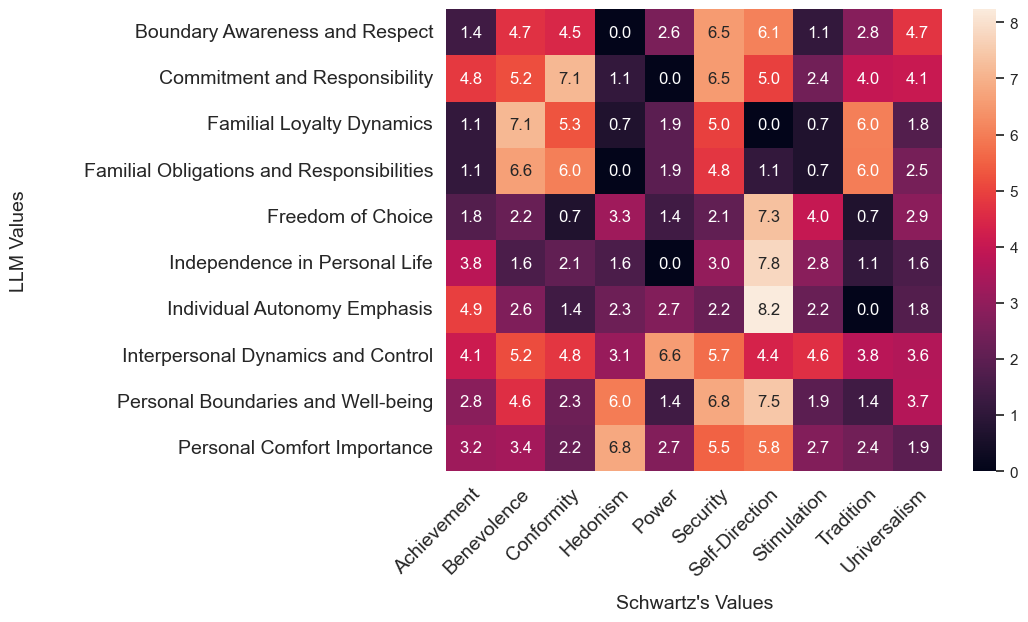

In [9]:
_values, _schwartz, _portion = [], [], []
for _value in [item[0] for item in value_cnt_sorted][:10]:
    sch_cnt = {key:0 for key in schwartz_values}
    for item in values_to_schwartz[_value]:
        if item.lower() in schwartz_values:
            _s = schwartz_values[schwartz_values.index(item.lower())]
            sch_cnt[_s] += 1
    all_cnt = sum(sch_cnt.values())
    if all_cnt == 0:
        continue
    for _sch in sch_cnt:
        _values.append(_value)
        _schwartz.append(s_to_S[_sch])
        # _portion.append(sch_cnt[_sch]/all_cnt)
        _portion.append(np.log(sch_cnt[_sch]+1))
        # _portion.append(sch_cnt[_sch])
        
df_heatmap = pd.DataFrame(data={'LLM Values':_values, "Schwartz's Values":_schwartz, 'portion':_portion})
df_heatmap_pv = df_heatmap.pivot(index="LLM Values", columns="Schwartz's Values", values="portion")

plt.figure(figsize=(8, 6))  # width=8 inches, height=6 inches
g = sns.heatmap(df_heatmap_pv, annot=True, fmt=".1f")
# g = sns.heatmap(df_heatmap_pv, annot=True)
# ax.set_xlabel('Sepal Length (cm)', fontsize=14)
# ax.set_ylabel('Frequency', fontsize=14)
# g.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right' , rotation_mode='anchor', fontsize=14)
# g.set_yticklabels(g.get_yticklabels(), fontsize=14)

g.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right' , rotation_mode='anchor', fontsize=14)
g.set_yticklabels(g.get_yticklabels(), fontsize=14)
g.set_ylabel("LLM Values", fontsize=14, labelpad=40, rotation=90)
g.set_xlabel("Schwartz's Values", fontsize=14, labelpad=10)


g

In [10]:
g.figure.savefig(f'{os.getcwd()}/diagram/cluster_to_schwartz.png', bbox_inches='tight')

<Axes: xlabel="Schwartz's Values", ylabel='LLM Values'>

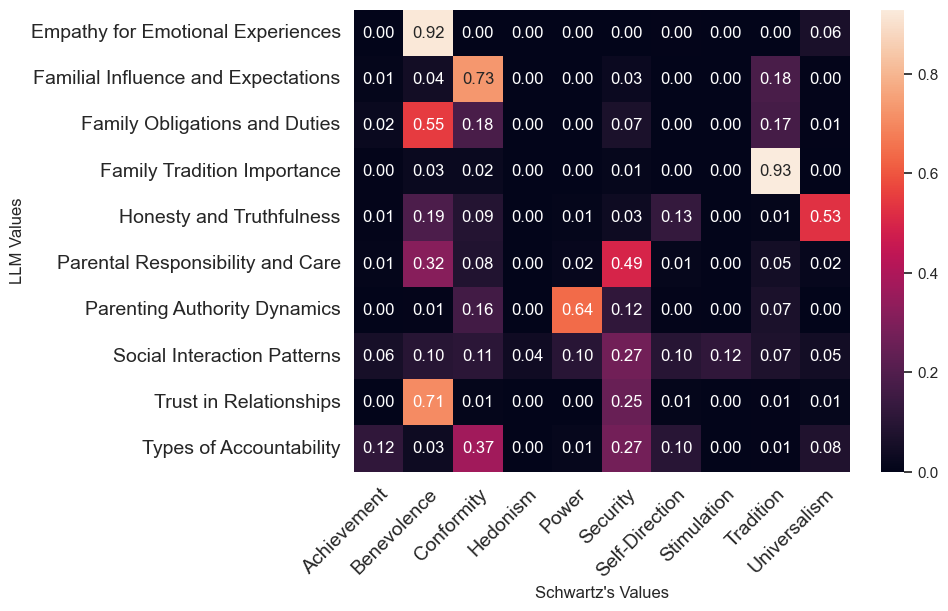

In [30]:
_values, _schwartz, _portion = [], [], []
for _value in [item[0] for item in value_cnt_sorted][10:20]:
    sch_cnt = {key:0 for key in schwartz_values}
    for item in values_to_schwartz[_value]:
        if item.lower() in schwartz_values:
            _s = schwartz_values[schwartz_values.index(item.lower())]
            sch_cnt[_s] += 1
    all_cnt = sum(sch_cnt.values())
    for _sch in sch_cnt:
        _values.append(_value)
        _schwartz.append(s_to_S[_sch])
        _portion.append(sch_cnt[_sch]/all_cnt)
        
df_heatmap = pd.DataFrame(data={'LLM Values':_values, "Schwartz's Values":_schwartz, 'portion':_portion})
df_heatmap_pv = df_heatmap.pivot(index="LLM Values", columns="Schwartz's Values", values="portion")

plt.figure(figsize=(8, 6))  # width=8 inches, height=6 inches
g = sns.heatmap(df_heatmap_pv, annot=True, fmt=".2f")
# ax.set_xlabel('Sepal Length (cm)', fontsize=14)
# ax.set_ylabel('Frequency', fontsize=14)
g.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right' , rotation_mode='anchor', fontsize=14)
g.set_yticklabels(g.get_yticklabels(), fontsize=14)

g

### conflicting value-schwartz heatmap

In [31]:
schwartz_conflicts = {
    'self-direction':['conformity', 'tradition', 'security'],
    'stimulation':['conformity', 'tradition', 'security'],
    'hedonism':['conformity', 'tradition', 'security'],
    'universalism':['power', 'achievement'],
    'benevolence':['power', 'achievement'],
    'conformity':['self-direction','hedonism', 'stimulation'],
    'tradition':['self-direction','hedonism', 'stimulation'],
    'security':['self-direction','hedonism', 'stimulation'],
    'power':['benevolence', 'universalism'], 
    'achievement':['benevolence', 'universalism']
}
schwartz_conflicts_1to1 = {
    'self-direction':['security'],
    'stimulation':['conformity', 'tradition'],
    'hedonism':['conformity', 'tradition'],
    'universalism':['power'],
    'benevolence':['achievement'],
    'conformity':['hedonism', 'stimulation'],
    'tradition':['hedonism', 'stimulation'],
    'security':['self-direction',],
    'power':[ 'universalism'], 
    'achievement':['benevolence',]
}

In [51]:
_values, _schwartz, _portion = [], [], []
for _value in list(values_to_schwartz.keys()):
    sch_cnt = {key:0 for key in schwartz_values}
    for item in values_to_schwartz[_value]:
        if item.lower() in schwartz_values:
            _s = schwartz_values[schwartz_values.index(item.lower())]
            sch_cnt[_s] += 1
    all_cnt = sum(sch_cnt.values())
    if all_cnt == 0:
        continue
    sch_portion = {key:val/all_cnt for key,val in sch_cnt.items()}
    write_condt = False
    for _key in sch_portion:
        if sch_portion[_key] > 0.14:
            # for _conf_key in schwartz_conflicts_1to1[_key]:
            for _conf_key in schwartz_conflicts[_key]:
                if sch_portion[_conf_key] > 0.14:
                    write_condt = True
    if write_condt:
        for _key in sch_portion:
            _values.append(_value)
            _schwartz.append(s_to_S[_key])
            _portion.append(sch_portion[_key])

<Axes: xlabel="Schwartz's Values", ylabel='LLM Values'>

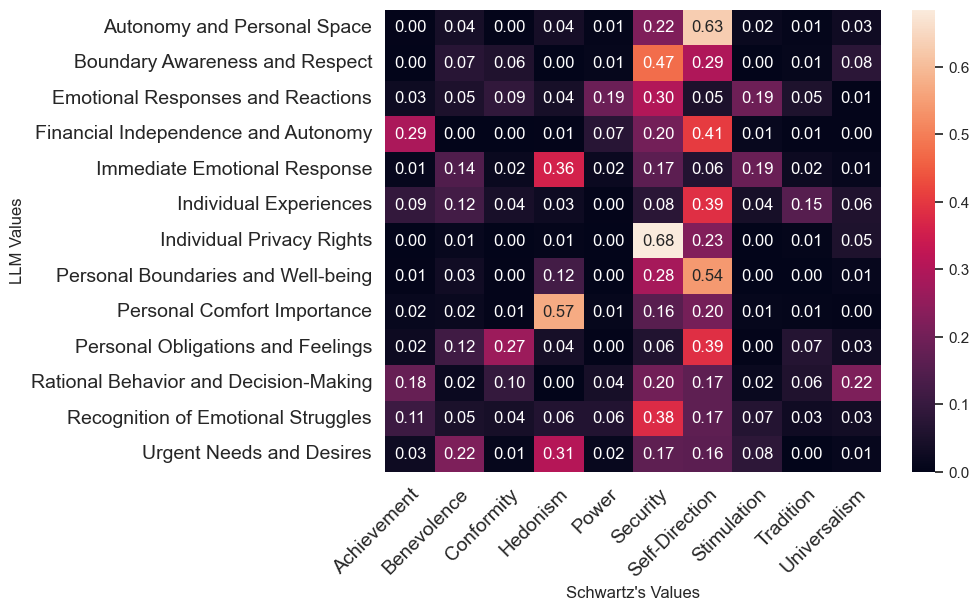

In [52]:
df_heatmap = pd.DataFrame(data={'LLM Values':_values, "Schwartz's Values":_schwartz, 'portion':_portion})

thr = 100
df_heatmap = df_heatmap[df_heatmap['LLM Values'].isin([item[0] for item in value_cnt_sorted][:thr])]
df_heatmap_pv = df_heatmap.pivot(index="LLM Values", columns="Schwartz's Values", values="portion")


plt.figure(figsize=(8, 6))  # width=8 inches, height=6 inches
g = sns.heatmap(df_heatmap_pv, annot=True, fmt=".2f")
g.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right' , rotation_mode='anchor', fontsize=14)
g.set_yticklabels(g.get_yticklabels(), fontsize=14)
g

<Axes: xlabel='value', ylabel='schwartz'>

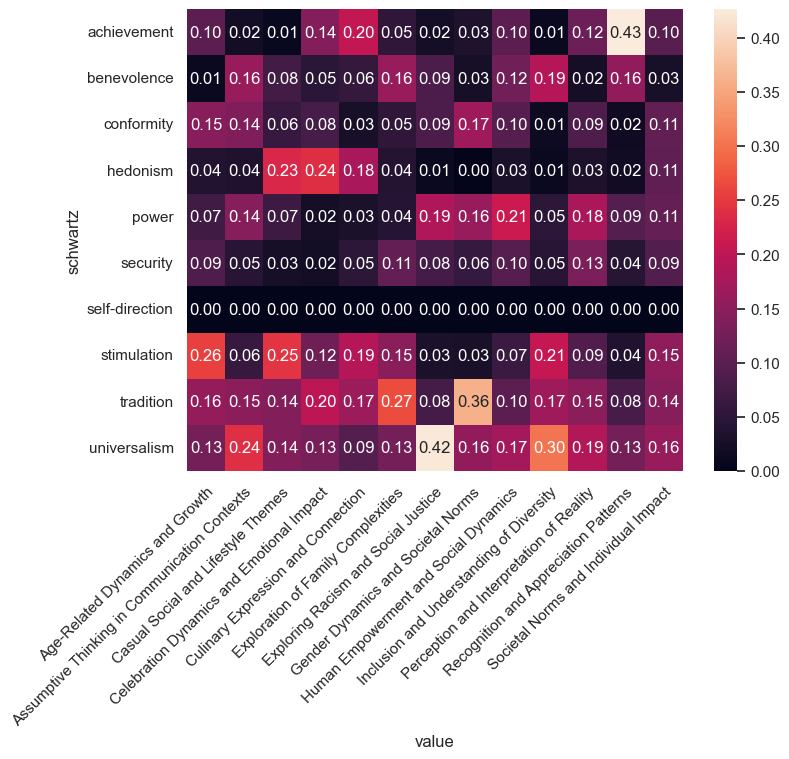

In [119]:
df_heatmap = pd.DataFrame(data={'value':_values, 'schwartz':_schwartz, 'portion':_portion})
df_heatmap_pv = df_heatmap.pivot(index="schwartz", columns="value", values="portion")

plt.figure(figsize=(8, 6))  # width=8 inches, height=6 inches
g = sns.heatmap(df_heatmap_pv, annot=True, fmt=".2f")
g.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right' , rotation_mode='anchor')
g

### Compute intra-cluster distance, Silhouette

In [24]:
minidf = df[df['commAuthor'].isin(AUTHORS)]
author_to_judgments = {_author:[] for _author in AUTHORS}
for idx, row in minidf.iterrows():
    author_to_judgments[row['commAuthor']].append(row['judgment'])

author_to_judgment_dist = {_author:sum(author_to_judgments[_author])/len(author_to_judgments[_author]) for _author in AUTHORS}

In [25]:
author_to_judgment_dist_tup = author_to_judgment_dist.items()
df_viz = pd.DataFrame(data={'authors':[elem[0] for elem in author_to_judgment_dist_tup], 'dists':[elem[1] for elem in author_to_judgment_dist_tup]})

<Axes: xlabel='dists', ylabel='Count'>

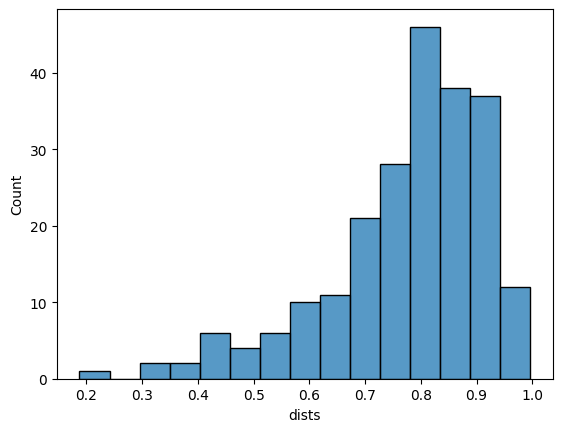

In [26]:
sns.histplot(data=df_viz, x="dists")

In [32]:
author_to_judgment_dist_s = sorted(author_to_judgment_dist.items(), key=lambda x:x[1])